In [1]:
import sys
sys.path.append("./Dependencies/")
import pylablib.devices.DCAM as DCAM
import motors as mot
import shutter as shutt
import filter_wheels as fw
import matplotlib.pyplot as plt
import matlab.engine
from measure import *
import RotationMotor as rot
import os
from skimage.filters import median
from Setup_class import Setup
import ipywidgets as widgets
import numpy as np
from tifffile import imsave
from Acquisition_f import *


"________OPHIR_______"
import win32gui
import win32com.client
import time
import traceback


#  Connect setup

In [2]:
eng = matlab.engine.start_matlab()
eng.addpath('C:\\Users\\NEXT-BOLD\\Documents\\SERGIO\\Autofocus')
'''_______________Motors_____________________'''
conn, xdrive, ydrive = mot.start_drives()
connz, zdrive = mot.connectZdrive(com='COM5')
'''_________________Filter wheels______________'''
FWxC,_ = fw.connectLowFilters();
hdl = fw.Start_Low_FilterWheel(FWxC);
h_filters = fw.start_HighFilters(eng)
'''_______________Shutter_______________'''
h_shutter = shutt.connectShutter(eng)
'''______________Rotation motor_________________'''
h_rotor=rot.start_Rotor(eng)
'''______________Hamamatsu camera________________'''
cam = DCAM.DCAMCamera(idx=0)
cam.set_attribute_value("BINNING",4)
'''_______________Ophir power meter______________'''
OphirCOM = win32com.client.Dispatch("OphirLMMeasurement.CoLMMeasurement")
# Stop & Close all devices
OphirCOM.StopAllStreams() 
OphirCOM.CloseAll()
# Scan for connected Devices
DeviceList = OphirCOM.ScanUSB()
print(DeviceList)
for Device in DeviceList:   	# if any device is connected
    DeviceHandle = OphirCOM.OpenUSBDevice(Device)	# open first device
    exists = OphirCOM.IsSensorExists(DeviceHandle, 0)
    OphirCOM.SetRange(DeviceHandle, 0, 4)

Found Device 1 SN: 74596 (X-NA08A25-E09) -> Connection 1 (ASCII Serial port: COM6) devices
Found Device 1 SN: 61516 (T-NA08A25) -> Connection 2 (Binary Serial port: COM5) devices
hdl =  0
Low filter wheel is opened,  1
('943894',)


# Define setup

In [3]:
stp = Setup(cam0=cam, eng=eng, h_filters=h_filters, h_rotor=h_rotor, shutter=h_shutter,
            xdrive=xdrive, ydrive=ydrive, zdrive=zdrive,Pmeter=OphirCOM,DeviceHandle=DeviceHandle)

# Camera darks

In [4]:
sp=LLDpath+'/'+setuppath+'/Hamamatsu Orca Flash 4.0  (C13440)/'
os.listdir(sp)

['.ipynb_checkpoints',
 'Analysis_darks.ipynb',
 'Darks',
 'MANUAL.pdf',
 'SCAS0134E_C13440-20CU_tec.pdf']

In [32]:
def Take_darks(name,N):
    sp=LLDpath+'/'+setuppath+'/Hamamatsu Orca Flash 4.0  (C13440)/{}/'.format(name)
    create_folder(sp)
    f = open(sp+"Dark_description.txt",'w')
    f.write('Binning={}'.format(stp.get_binning()))
    f.write('Exposure={}'.format(stp.get_exposure()))
    f.write('Number f frames={}'.format(N))
    com=input('Comments about frames:')
    f.write('Comments about frames: {}'.format(com))
    f.close()
    for num in range(N):
        f=stp.frame()
        np.savetxt(sp+'Dark{}.txt'.format(num),f,fmt='%i')
    
    

In [35]:
stp.get_binning()
stp.set_exposure(0.1)

In [36]:
Take_darks('Darks_bin4_exp0.1_prueba',100)

[WinError 183] No se puede crear un archivo que ya existe: 'C:\\Users\\NEXT-BOLD\\Documents\\MIKEL\\LaserLab Dropbox/Proyectos/Setup/NF_setup0/Hamamatsu Orca Flash 4.0  (C13440)/Darks_bin4_exp0.1_prueba/'
Do you want to continue writting?y
Comments about frames:


# Control de potencia

In [13]:
stp.rotation(0)
time.sleep(1)
stp.start_stream()
for i in range (0,90,5):
    stp.rotation(i)
p,t=stp.get_power()
stp.close_stream()

Text(0, 0.5, 'Power($\\mu$W)')

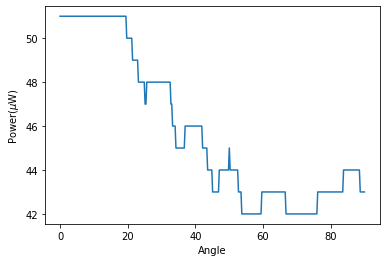

In [14]:
angle=(t-t[0])*90/(t[-1]-t[0])
plt.figure()
plt.plot(angle,p*1e6)
plt.xlabel("Angle")
plt.ylabel("Power($\mu$W)")  

## Power

In [15]:
stp.rotation(45)
stp.close_stream()

In [16]:
stp.open_shutter()
#time.sleep(1)
stp.start_stream() 
time.sleep(40)
p,t=stp.get_power()
stp.close_stream()
stp.close_shutter()

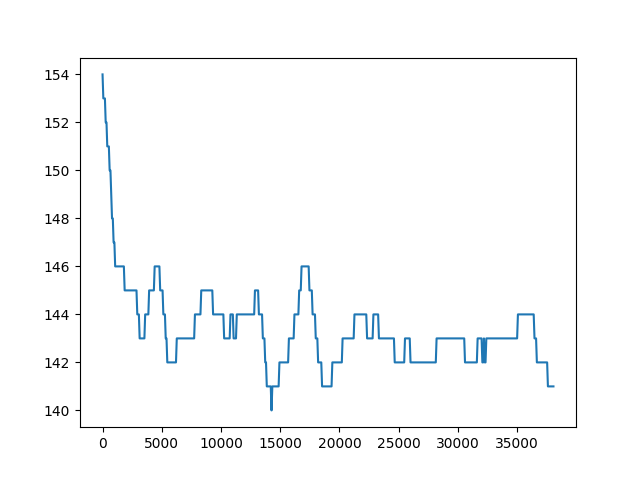

In [13]:
%matplotlib widget
t_real=t-t[0]
plt.plot(t_real,p*1e6)

# New sample

In [68]:
New_sample()

Write the name of the sample:
VS054_ANN205_D1
Select molecule:
['None', 'G0', 'G0-Sl', 'G1', 'G1-Sl', 'G2', 'G2-Sl', 'Ir-Sl', 'Ru-Sl']
None


Select substrate:
['ITO', 'Quartz']
Quartz

Select deposition method:
['None', 'Evaporation', 'Spin Coating', 'Dip Coating']
Dip Coating

Add description (optional):




# Select sample

In [17]:
os.listdir(datapath)

['BOLD 146 A1',
 'Canfranc2P1Pmay',
 'G0_load_lock',
 'G0_sample_prep',
 'ITO',
 'QUARTZ',
 'Silicon_oxide',
 'VS022_D1',
 'VS026_A1',
 'VS026_B1',
 'VS026_C1',
 'VS026_D2',
 'VS029_A1',
 'VS029_B1',
 'VS029_C1',
 'VS029_D1',
 'VS029_F1',
 'VS033_B1',
 'VS033_E1',
 'VS045_A1',
 'VS045_A2',
 'VS045_D1_Ba2',
 'VS045_D2_Ba2',
 'VS054_ANN205_A1',
 'VS054_ANN205_B1',
 'VS054_ANN205_C1',
 'VS054_ANN205_D1',
 'VS926_A1']

In [28]:
sample='VS0
D1'

# Enfoque

In [19]:
y0=15.4
z0=20.14
stp.set_y(y0)
stp.set_z(z0)

x0=20.95
x1=21.05
#stp.set_x(x0)
step=1

In [20]:
stp.set_exposure(0.1)
xs,arr,xpos=Autofocus(y0,z0,x0,x1,step,stp)

Text(0, 0.5, 'Counts (a.u.)')

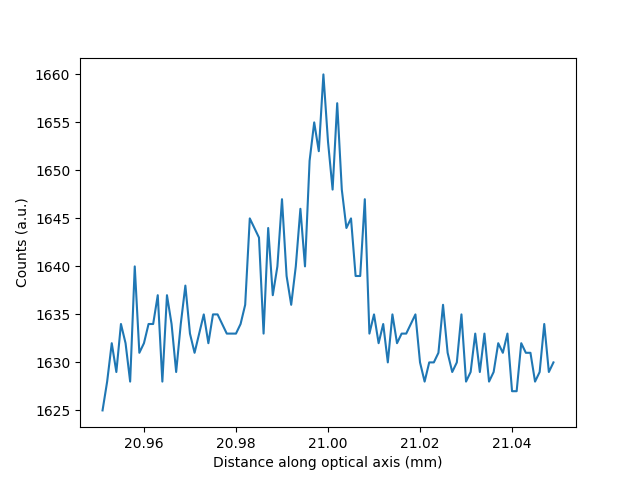

In [21]:
%matplotlib widget
plt.figure()
plt.plot(xs,arr)
plt.xlabel('Distance along optical axis (mm)')
plt.ylabel('Counts (a.u.)')

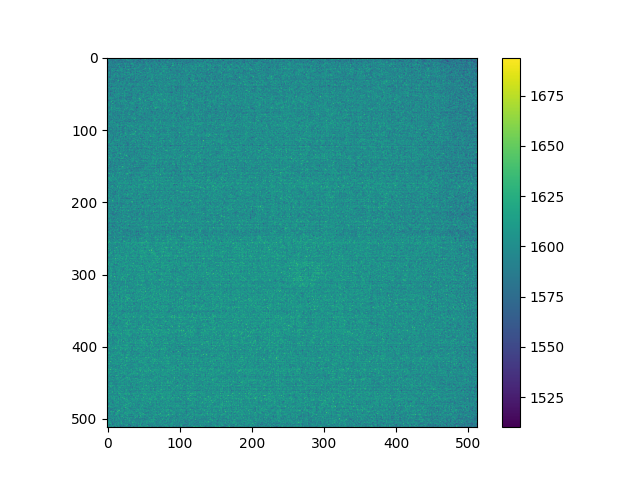

In [30]:
%matplotlib widget
posfocus=xpos
stp.set_x(xpos-0.04)
stp.set_filter(0)
stp.set_exposure(0.1)

stp.open_shutter()
f=stp.frame()
#stp.close_shutter()

plt.figure()
plt.imshow(f)
plt.colorbar()


In [27]:
stp.set_x(xpos)
stp.open_shutter()
stp.set_filter(0)

In [28]:
 stp.close_shutter()


# Scanning

In [31]:
xpos

24.057000000000002

Has it Barium? (YES/NO)No
Description:


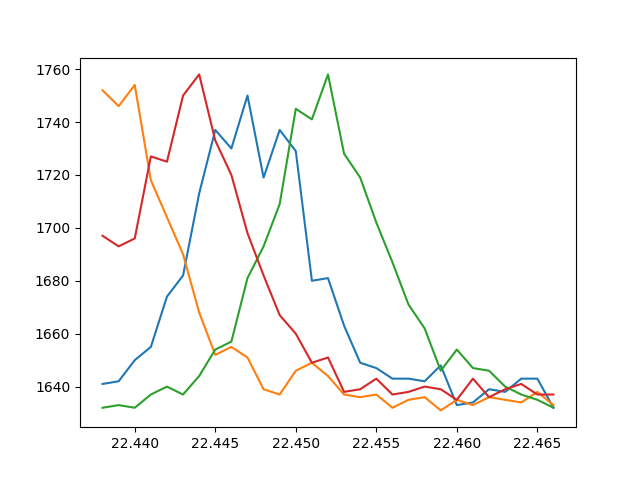

In [80]:
ys=[23.9,24.3]
zs=[23.4,23.8]
Scan(ys,zs,xpos,texp_f=0.1,texp_im=1,ran=15,sample=sample,runame='Scan1',stp=stp)



# Photobleaching

In [29]:
sample

'VS022_D1'

In [44]:
stp.close_stream()
stp.set_exposure(1)
data=Photobleaching(sample,'p6',100,6,0,stp)

DCAMLibError: function 'dcamprop_setgetvalue' raised error -2097147902 (DCAMERR_FAILREADCAMERA)